<a href="https://colab.research.google.com/github/Zdenkaaa/Final-Project---Brain-Tumor/blob/main/Final_project_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#**Pripojenie Google Drive**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#**Import potrebných knižníc**
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# **Cesta k datasetu**
os.chdir('/content/drive/My Drive/tumor')

In [ ]:
os.listdir()

# Triedy obrázkov (zložky s obrázkami)
classes = {"1": "meningioma", "2": "glioma", "3": "pituitary tumor"}

# Základná cesta, kde sa nachádzajú zložky 1, 2, 3
base_path = "."  # alebo absolútna cesta napr. "/path/to/project"

# Zoznamy na uloženie spracovaných dát a labelov
data = []
labels = []

# Pre každú zložku
for zlozka in classes.keys():
    # Cesta k aktuálnej zložke
    cesta_zlozka = os.path.join(base_path, zlozka)

    # Skontroluj, či priečinok existuje
    if not os.path.exists(cesta_zlozka):
        print(f"Priečinok {cesta_zlozka} neexistuje. Skontroluj cestu.")
        continue

    # Pre každý obrázok v zložke
    for obrazok in os.listdir(cesta_zlozka):
        if obrazok.endswith(".png"):
            print(f"Načítavam: {obrazok} z triedy {classes[zlozka]}")
            cesta_aktualny_obrazok = os.path.join(cesta_zlozka, obrazok)

            try:
                image = Image.open(cesta_aktualny_obrazok).convert("RGB")
                image = image.resize((128, 128))  # Nová veľkosť 128x128
                image_array = np.array(image) / 255.0  # Normalizácia
                data.append(image_array)
                labels.append(int(zlozka))

            except Exception as e:
                print(f"Chyba pri spracovaní obrázku {cesta_aktualny_obrazok}: {e}")

# Prevod na numpy arrays
train_data = np.array(data)
labels = [int(zlozka) - 1 for zlozka in labels]  # Posun na 0, 1, 2
train_labels = to_categorical(np.array(labels), num_classes=3)

# Rozdelenie dát na tréningové a testovacie množiny
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print("Tvar tréningových obrázkov:", X_train.shape)
print("Tvar testovacích obrázkov:", X_test.shape)
print("Tvar tréningových labelov:", y_train.shape)
print("Tvar testovacích labelov:", y_test.shape)


Načítavam: 2300.png z triedy meningioma
Načítavam: 2304.png z triedy meningioma
Načítavam: 2307.png z triedy meningioma
Načítavam: 2302.png z triedy meningioma
Načítavam: 2301.png z triedy meningioma
Načítavam: 2303.png z triedy meningioma
Načítavam: 2305.png z triedy meningioma
Načítavam: 2306.png z triedy meningioma
Načítavam: 2308.png z triedy meningioma
Načítavam: 2327.png z triedy meningioma
Načítavam: 2311.png z triedy meningioma
Načítavam: 2312.png z triedy meningioma
Načítavam: 2320.png z triedy meningioma
Načítavam: 2332.png z triedy meningioma
Načítavam: 2331.png z triedy meningioma
Načítavam: 2333.png z triedy meningioma
Načítavam: 2313.png z triedy meningioma
Načítavam: 2324.png z triedy meningioma
Načítavam: 2316.png z triedy meningioma
Načítavam: 2310.png z triedy meningioma
Načítavam: 2323.png z triedy meningioma
Načítavam: 2314.png z triedy meningioma
Načítavam: 2318.png z triedy meningioma
Načítavam: 2321.png z triedy meningioma
Načítavam: 2326.png z triedy meningioma


In [ ]:
# **Vytvorenie modelu pomocou transfer learning (VGG16)**
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Zamrznutie pôvodných vrstiev (nechceme ich trénovať)
for layer in vgg16.layers:
    layer.trainable = False

# Pridanie vlastnej klasifikačnej hlavy
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

# Finalizácia modelu
model = Model(inputs=vgg16.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Výpis štruktúry modelu
model.summary()

# **Tréning modelu**
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Definovanie checkpointu na ukladanie najlepšieho modelu
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    mode="auto",
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=100,
    callbacks=[checkpoint, early_stopping]
)

# **Uloženie modelu**
model.save("brain_tumor_classifier.keras")

print("Model bol úspešne natrénovaný a uložený.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 2,098,179 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.4644 - loss: 2.1535
Epoch 1: val_accuracy improved from -inf to 0.75856, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4690 - loss: 2.1243 - val_accuracy: 0.7586 - val_loss: 0.6378
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7956 - loss: 0.5023
Epoch 2: val_accuracy improved from 0.75856 to 0.83361, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.7959 - loss: 0.5011 - val_accuracy: 0.8336 - val_loss: 0.4417
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8531 - loss: 0.3773
Epoch 3: val_accuracy improved from 0.83361 to 0.85155, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8531 - loss: 0.3771 - val_accuracy: 0.8515 - val_loss: 0.3730
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8669 - loss: 0.3288
Epoch 4: val_accuracy improved from 0.8515

In [ ]:
# Vyhodnotenie modelu na testovacích dátach
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Presnosť modelu na testovacích dátach: {test_accuracy * 100:.2f}%")
print(f"Testovacia strata: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9184 - loss: 0.1890
Presnosť modelu na testovacích dátach: 93.31%
Testovacia strata: 0.1804


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


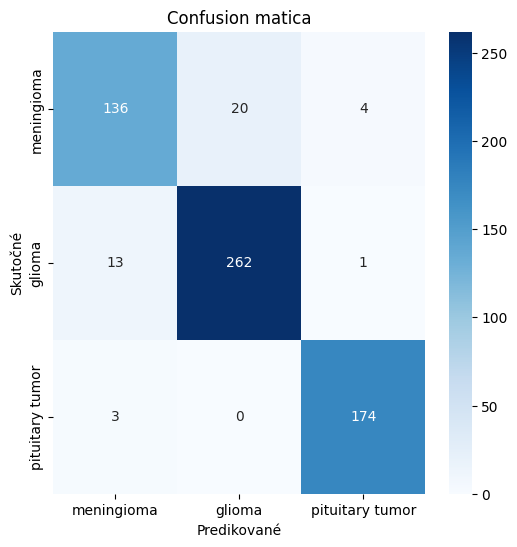

In [ ]:
# **Confusion Matica**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel("Predikované")
plt.ylabel("Skutočné")
plt.title("Confusion matica")
plt.show()

In [ ]:
# **Vyhodnotenie modelu: Precision, Recall, F1-Score**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nKlasifikačná správa:")
print(classification_report(y_true, y_pred_classes, target_names=classes.values()))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Klasifikačná správa:
                 precision    recall  f1-score   support

     meningioma       0.89      0.85      0.87       160
         glioma       0.93      0.95      0.94       276
pituitary tumor       0.97      0.98      0.98       177

       accuracy                           0.93       613
      macro avg       0.93      0.93      0.93       613
   weighted avg       0.93      0.93      0.93       613



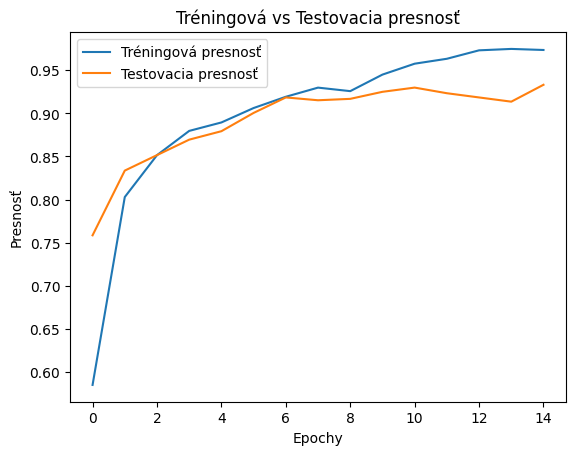

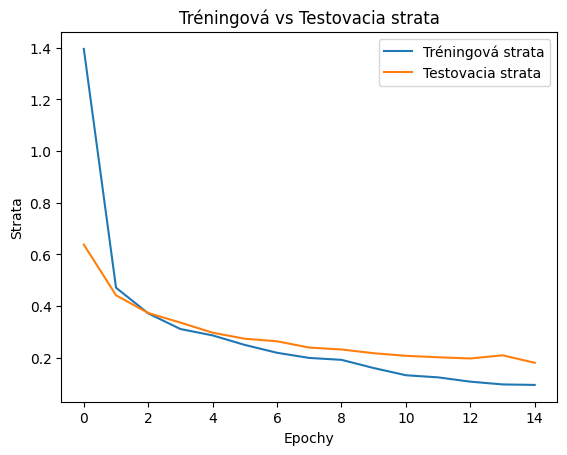

In [ ]:
# Graf presnosti
plt.plot(history.history['accuracy'], label='Tréningová presnosť')
plt.plot(history.history['val_accuracy'], label='Testovacia presnosť')
plt.xlabel('Epochy')
plt.ylabel('Presnosť')
plt.legend()
plt.title('Tréningová vs Testovacia presnosť')
plt.show()

# Graf straty
plt.plot(history.history['loss'], label='Tréningová strata')
plt.plot(history.history['val_loss'], label='Testovacia strata')
plt.xlabel('Epochy')
plt.ylabel('Strata')
plt.legend()
plt.title('Tréningová vs Testovacia strata')
plt.show()

In [ ]:
# **Načítanie natrénovaného modelu**
model = load_model("brain_tumor_classifier.keras")

# **Funkcia na predikciu nového obrázka**
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Pridanie dimenzie pre batch

    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    class_names = ["meningioma", "glioma", "pituitary tumor"]
    print(f"Predikcia: {class_names[predicted_class]}")

# **Predikcia nového obrázka zo zložky 'Nahoda'**
predict_image("Nahoda/3059.png")  # Nahraď názvom skutočného súboru

NameError: name 'load_model' is not defined

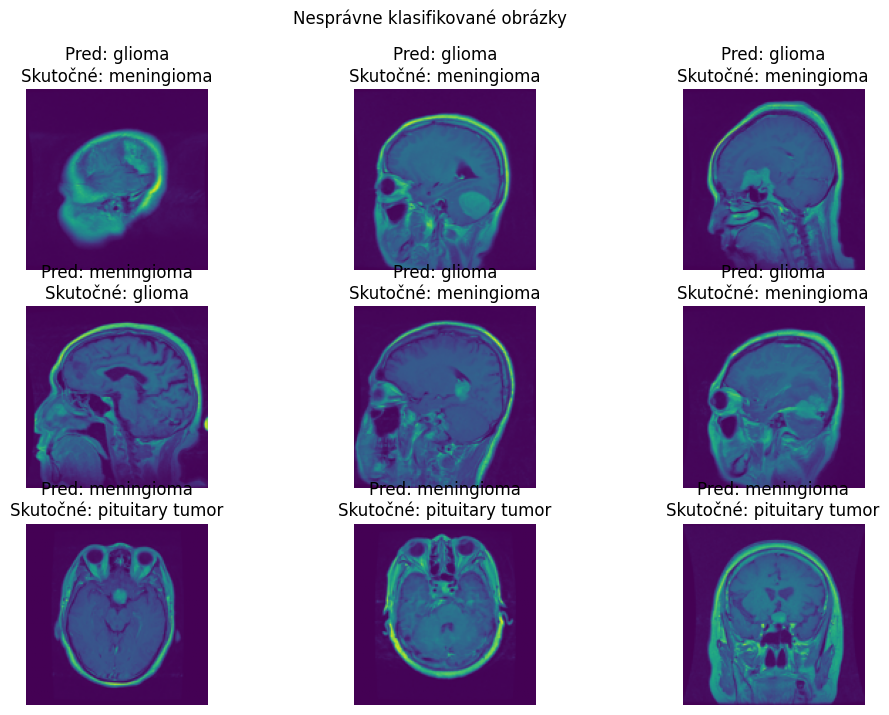

In [ ]:
# **Vizualizácia nesprávne klasifikovaných obrázkov**
misclassified_idx = np.where(y_pred_classes != y_true)[0]
plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_idx[:9]):  # Zobrazíme prvých 9 nesprávnych predikcií
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Pred: {classes[str(y_pred_classes[idx] + 1)]}\nSkutočné: {classes[str(y_true[idx] + 1)]}")
    plt.axis('off')
plt.suptitle("Nesprávne klasifikované obrázky")
plt.show()


In [ ]:
# **Vytvorenie modelu VGG16 bez zmrazenia vrstiev**
vgg16_unfrozen = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in vgg16_unfrozen.layers:
    layer.trainable = True  # Trénujeme všetky vrstvy

# Pridanie klasifikačnej hlavy
x = Flatten()(vgg16_unfrozen.output)
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout na redukciu pretrénovania
x = Dense(3, activation='softmax')(x)

# Vytvorenie modelu
vgg16_unfrozen_model = Model(inputs=vgg16_unfrozen.input, outputs=x)
from tensorflow.keras.optimizers import SGD

vgg16_unfrozen_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),  # Zmena optimizéra na SGD
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definovanie checkpointu a early stopping
checkpoint_unfrozen = ModelCheckpoint("best_vgg16_unfrozen_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stopping_unfrozen = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=5, mode="auto", restore_best_weights=True)

# Tréning modelu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Použitie augmentácie na tréningové dáta
augmented_train = datagen.flow(X_train, y_train, batch_size=64)

history_unfrozen = vgg16_unfrozen_model.fit(
    augmented_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Zvýšené na 30 epoch
    callbacks=[checkpoint_unfrozen, early_stopping_unfrozen]
)

# Uloženie modelu
vgg16_unfrozen_model.save("vgg16_unfrozen_brain_tumor_classifier.keras")
print("Model VGG16 bez zmrazenia vrstiev bol úspešne natrénovaný a uložený.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.5135 - loss: 5.9839
Epoch 1: val_accuracy improved from -inf to 0.73736, saving model to best_vgg16_unfrozen_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 67s 795ms/step - accuracy: 0.5155 - loss: 5.9803 - val_accuracy: 0.7374 - val_loss: 5.5325
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7342 - loss: 5.4749
Epoch 2: val_accuracy improved from 0.73736 to 0.77162, saving model to best_vgg16_unfrozen_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.7346 - loss: 5.4740 - val_accuracy: 0.7716 - val_loss: 5.3542
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8299 - loss: 5.2244
Epoch 3: val_accuracy improved from 0.77162 to 0.84176, saving model to best_vgg16_unfrozen_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - accuracy: 0.8301 - loss: 5.2233 - val_accuracy: 0.8418 - val_loss: 5.2065
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8627 - loss: 

In [ ]:
# **Vyhodnotenie modelu**
loss, accuracy = vgg16_unfrozen_model.evaluate(X_test, y_test)
print(f'Presnosť modelu na testovacej množine: {accuracy * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9598 - loss: 4.0788
Presnosť modelu na testovacej množine: 95.27%


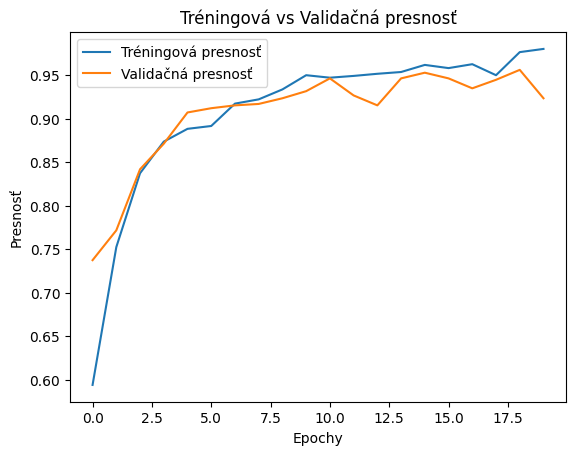

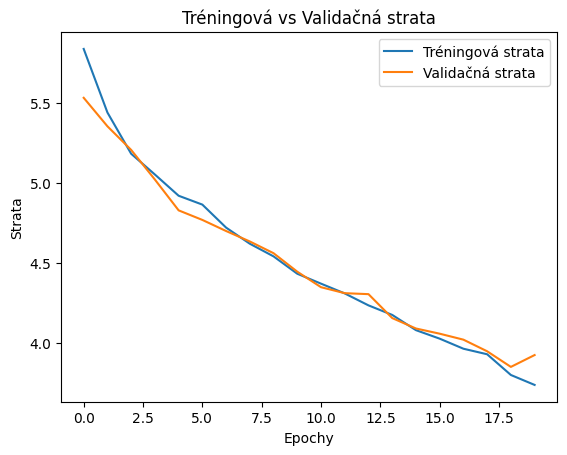

In [ ]:
# Graf presnosti
plt.plot(history_unfrozen.history['accuracy'], label='Tréningová presnosť')
plt.plot(history_unfrozen.history['val_accuracy'], label='Validačná presnosť')
plt.xlabel('Epochy')
plt.ylabel('Presnosť')
plt.legend()
plt.title('Tréningová vs Validačná presnosť')
plt.show()

# Graf straty
plt.plot(history_unfrozen.history['loss'], label='Tréningová strata')
plt.plot(history_unfrozen.history['val_loss'], label='Validačná strata')
plt.xlabel('Epochy')
plt.ylabel('Strata')
plt.legend()
plt.title('Tréningová vs Validačná strata')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


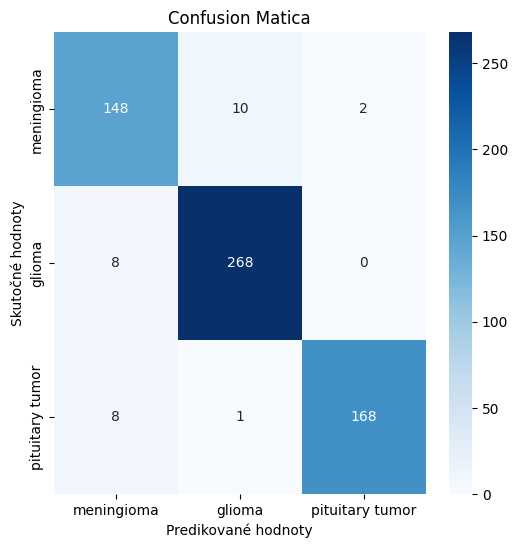

Klasifikačná správa:
                 precision    recall  f1-score   support

     meningioma       0.90      0.93      0.91       160
         glioma       0.96      0.97      0.97       276
pituitary tumor       0.99      0.95      0.97       177

       accuracy                           0.95       613
      macro avg       0.95      0.95      0.95       613
   weighted avg       0.95      0.95      0.95       613



In [ ]:
# **Generovanie confusion matice**
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predikcia na testovacej množine
y_pred = vgg16_unfrozen_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konvertovanie one-hot encodingu na triedy
y_true = np.argmax(y_test, axis=1)  # Skutočné triedy

# Vytvorenie confusion matice
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.title('Confusion Matica')
plt.show()


# Výpis klasifikačnej správy
print("Klasifikačná správa:")
print(classification_report(y_true, y_pred_classes, target_names=["meningioma", "glioma", "pituitary tumor"]))


In [ ]:
# **Grad-CAM Vizualizácia-Zdôrazňuje oblasti, ktoré model považuje za dôležité pri klasifikácii**
import tensorflow.keras.backend as K
import cv2

def grad_cam(model, image_path, layer_name='block5_conv3'):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((128, 128))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, np.argmax(predictions)]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite("grad_cam_output.jpg", superimposed_img)

    print("Grad-CAM uložený ako 'grad_cam_output.jpg'")

# Vizualizácia na novom obrázku
image_path = "Nahoda/3059.png"  # Cesta k obrázku na predikciu
grad_cam(vgg16_unfrozen_model, image_path)

Grad-CAM uložený ako 'grad_cam_output.jpg'


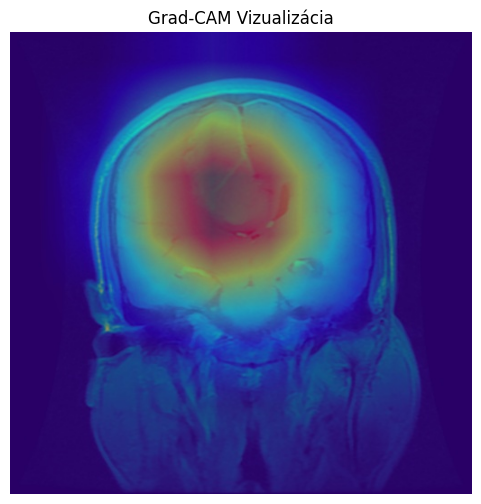

In [ ]:
# **Zobrazenie Grad-CAM obrázka**
# Načítanie obrázka
image = cv2.imread("grad_cam_output.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Zobrazenie obrázka
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.title('Grad-CAM Vizualizácia')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

In [ ]:
os.listdir()

# Triedy obrázkov (zložky s obrázkami)
classes = {"1": "meningioma", "2": "glioma", "3": "pituitary tumor"}

# Základná cesta, kde sa nachádzajú zložky 1, 2, 3
base_path = "."  # alebo absolútna cesta napr. "/path/to/project"

# Zoznamy na uloženie spracovaných dát a labelov
data = []
labels = []

# Pre každú zložku
for zlozka in classes.keys():
    # Cesta k aktuálnej zložke
    cesta_zlozka = os.path.join(base_path, zlozka)

    # Skontroluj, či priečinok existuje
    if not os.path.exists(cesta_zlozka):
        print(f"Priečinok {cesta_zlozka} neexistuje. Skontroluj cestu.")
        continue

    # Pre každý obrázok v zložke
    for obrazok in os.listdir(cesta_zlozka):
        if obrazok.endswith(".png"):
            print(f"Načítavam: {obrazok} z triedy {classes[zlozka]}")
            cesta_aktualny_obrazok = os.path.join(cesta_zlozka, obrazok)

            try:
                image = Image.open(cesta_aktualny_obrazok).convert("RGB")
                image = image.resize((128, 128))  # Nová veľkosť 128x128
                image_array = np.array(image) / 255.0  # Normalizácia
                data.append(image_array)
                labels.append(int(zlozka))

            except Exception as e:
                print(f"Chyba pri spracovaní obrázku {cesta_aktualny_obrazok}: {e}")

# Prevod na numpy arrays
train_data = np.array(data)
labels = [int(zlozka) - 1 for zlozka in labels]  # Posun na 0, 1, 2
train_labels = to_categorical(np.array(labels), num_classes=3)

# Rozdelenie dát na tréningové a testovacie množiny
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# **Silnejšia augmentácia dát**
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)



Načítavam: 2300.png z triedy meningioma
Načítavam: 2304.png z triedy meningioma
Načítavam: 2307.png z triedy meningioma
Načítavam: 2302.png z triedy meningioma
Načítavam: 2301.png z triedy meningioma
Načítavam: 2303.png z triedy meningioma
Načítavam: 2305.png z triedy meningioma
Načítavam: 2306.png z triedy meningioma
Načítavam: 2308.png z triedy meningioma
Načítavam: 2327.png z triedy meningioma
Načítavam: 2311.png z triedy meningioma
Načítavam: 2312.png z triedy meningioma
Načítavam: 2320.png z triedy meningioma
Načítavam: 2332.png z triedy meningioma
Načítavam: 2331.png z triedy meningioma
Načítavam: 2333.png z triedy meningioma
Načítavam: 2313.png z triedy meningioma
Načítavam: 2324.png z triedy meningioma
Načítavam: 2316.png z triedy meningioma
Načítavam: 2310.png z triedy meningioma
Načítavam: 2323.png z triedy meningioma
Načítavam: 2314.png z triedy meningioma
Načítavam: 2318.png z triedy meningioma
Načítavam: 2321.png z triedy meningioma
Načítavam: 2326.png z triedy meningioma


In [ ]:
# **Vytvorenie modelu pomocou EfficientNetB0**
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Odmrazenie posledných 20 vrstiev
for layer in efficientnet.layers[:-20]:
    layer.trainable = False
for layer in efficientnet.layers[-20:]:
    layer.trainable = True

# Pridanie vlastnej klasifikačnej hlavy
x = GlobalAveragePooling2D()(efficientnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Pridaný dropout na redukciu overfittingu
x = Dense(3, activation='softmax')(x)

# Finalizácia modelu
model = Model(inputs=efficientnet.input, outputs=x)
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# **Tréning modelu**
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=7,
    mode="auto",
    restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

# **Uloženie modelu**
model.save("brain_tumor_classifier_efficientnet.keras")

print("Model bol úspešne natrénovaný a uložený.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4465 - loss: 1.0906
Epoch 1: val_accuracy improved from -inf to 0.28874, saving model to best_model_efficientnet.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 457ms/step - accuracy: 0.4464 - loss: 1.0907 - val_accuracy: 0.2887 - val_loss: 1.1403
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4397 - loss: 1.0881
Epoch 2: val_accuracy did not improve from 0.28874
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.4398 - loss: 1.0880 - val_accuracy: 0.2887 - val_loss: 1.0954
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4127 - loss: 1.0947
Epoch 3: val_accuracy improved from 0.28874 to 0.45024, saving model to best_model_efficientnet.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.4131 - loss: 1.0945 - val_accuracy: 0.4502 - val_loss: 1.0721
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4684 - loss: 1.0684
Epoch 4: val_accuracy did not improve from 0.45024

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

In [ ]:
os.listdir()

# Triedy obrázkov (zložky s obrázkami)
classes = {"1": "meningioma", "2": "glioma", "3": "pituitary tumor"}

# Základná cesta, kde sa nachádzajú zložky 1, 2, 3
base_path = "."  # alebo absolútna cesta napr. "/path/to/project"

# Zoznamy na uloženie spracovaných dát a labelov
data = []
labels = []

# Pre každú zložku
for zlozka in classes.keys():
    # Cesta k aktuálnej zložke
    cesta_zlozka = os.path.join(base_path, zlozka)

    # Skontroluj, či priečinok existuje
    if not os.path.exists(cesta_zlozka):
        print(f"Priečinok {cesta_zlozka} neexistuje. Skontroluj cestu.")
        continue

    # Pre každý obrázok v zložke
    for obrazok in os.listdir(cesta_zlozka):
        if obrazok.endswith(".png"):
            print(f"Načítavam: {obrazok} z triedy {classes[zlozka]}")
            cesta_aktualny_obrazok = os.path.join(cesta_zlozka, obrazok)

            try:
                image = Image.open(cesta_aktualny_obrazok).convert("RGB")
                image = image.resize((128, 128))  # Nová veľkosť 128x128
                image_array = np.array(image) / 255.0  # Normalizácia
                data.append(image_array)
                labels.append(int(zlozka))

            except Exception as e:
                print(f"Chyba pri spracovaní obrázku {cesta_aktualny_obrazok}: {e}")

# Prevod na numpy arrays
train_data = np.array(data)
labels = [int(zlozka) - 1 for zlozka in labels]  # Posun na 0, 1, 2
train_labels = to_categorical(np.array(labels), num_classes=3)

# Rozdelenie dát na tréningové a testovacie množiny
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# **Silnejšia augmentácia dát**
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)


Načítavam: 2300.png z triedy meningioma
Načítavam: 2304.png z triedy meningioma
Načítavam: 2307.png z triedy meningioma
Načítavam: 2302.png z triedy meningioma
Načítavam: 2301.png z triedy meningioma
Načítavam: 2303.png z triedy meningioma
Načítavam: 2305.png z triedy meningioma
Načítavam: 2306.png z triedy meningioma
Načítavam: 2308.png z triedy meningioma
Načítavam: 2327.png z triedy meningioma
Načítavam: 2311.png z triedy meningioma
Načítavam: 2312.png z triedy meningioma
Načítavam: 2320.png z triedy meningioma
Načítavam: 2332.png z triedy meningioma
Načítavam: 2331.png z triedy meningioma
Načítavam: 2333.png z triedy meningioma
Načítavam: 2313.png z triedy meningioma
Načítavam: 2324.png z triedy meningioma
Načítavam: 2316.png z triedy meningioma
Načítavam: 2310.png z triedy meningioma
Načítavam: 2323.png z triedy meningioma
Načítavam: 2314.png z triedy meningioma
Načítavam: 2318.png z triedy meningioma
Načítavam: 2321.png z triedy meningioma
Načítavam: 2326.png z triedy meningioma


In [ ]:
# **Vytvorenie modelu pomocou EfficientNetB3**
efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Odmrazenie posledných 20 vrstiev
for layer in efficientnet.layers[:-20]:
    layer.trainable = False
for layer in efficientnet.layers[-20:]:
    layer.trainable = True

# Pridanie vlastnej klasifikačnej hlavy
x = GlobalAveragePooling2D()(efficientnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Pridaný dropout na redukciu overfittingu
x = Dense(3, activation='softmax')(x)

# Finalizácia modelu
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model = Model(inputs=efficientnet.input, outputs=x)
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5), loss=loss_fn, metrics=['accuracy'])

# **Implementácia Cyclical Learning Rate (CLR)**
class CyclicLR(Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=5):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.iterations = 0

    def on_train_batch_begin(self, batch, logs=None):
        self.iterations += 1
        new_lr = self.base_lr + (self.max_lr - self.base_lr) * (1 + np.cos(self.iterations / self.step_size * np.pi)) / 2
        K.set_value(self.model.optimizer.learning_rate, new_lr)

clr = CyclicLR(base_lr=1e-5, max_lr=1e-3, step_size=10)

# **Tréning modelu**
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=7,
    mode="auto",
    restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping, clr]
)

# **Uloženie modelu**
model.save("brain_tumor_classifier_efficientnet.keras")

print("Model bol úspešne natrénovaný a uložený.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


AttributeError: 'str' object has no attribute 'name'

In [ ]:
# **Vyhodnotenie modelu**
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predikcia na testovacej množine
y_pred = efficientnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konvertovanie one-hot encodingu na triedy
y_true = np.argmax(y_test, axis=1)  # Skutočné triedy

# Vytvorenie confusion matice
conf_matrix = confusion_matrix(y_true, y_pred_classes, labels=[0, 1, 2])

# Overenie distribúcie predikovaných tried
unique, counts = np.unique(y_pred_classes, return_counts=True)
print("Distribúcia predikovaných tried:", dict(zip(unique, counts)))
plt.figure(figsize=(6, 6))
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=["Meningioma", "Glioma", "Pituitary Tumor"],
            yticklabels=["Meningioma", "Glioma", "Pituitary Tumor"])
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.title('Confusion Matica - EfficientNetB0')
plt.show()

# Výpis klasifikačnej správy
print("Klasifikačná správa:")
print(classification_report(y_true, y_pred_classes, target_names=classes.values()))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# Triedy obrázkov (zložky s obrázkami)
classes = {"1": "meningioma", "2": "glioma", "3": "pituitary tumor"}

# Základná cesta, kde sa nachádzajú zložky 1, 2, 3
base_path = "."  # alebo absolútna cesta

# Načítanie a spracovanie dát
data = []
labels = []
for zlozka in classes.keys():
    cesta_zlozka = os.path.join(base_path, zlozka)
    if not os.path.exists(cesta_zlozka):
        print(f"Priečinok {cesta_zlozka} neexistuje.")
        continue
    for obrazok in os.listdir(cesta_zlozka):
        if obrazok.endswith(".png"):
            cesta_aktualny_obrazok = os.path.join(cesta_zlozka, obrazok)
            try:
                image = Image.open(cesta_aktualny_obrazok).convert("RGB")
                image = image.resize((128, 128))
                image_array = np.array(image) / 255.0
                data.append(image_array)
                labels.append(int(zlozka))
            except Exception as e:
                print(f"Chyba pri spracovaní obrázku {cesta_aktualny_obrazok}: {e}")

# Konverzia do numpy array a rozdelenie datasetu
from tensorflow.keras.applications.resnet import preprocess_input

train_data = np.array(data)
train_data = preprocess_input(train_data)  # **Použitie preprocess_input pre ResNet50**
labels = [int(zlozka) - 1 for zlozka in labels]
train_labels = to_categorical(np.array(labels), num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
# **Vytvorenie modelu ResNet50 s čiastočne odomknutými vrstvami**
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in resnet.layers[:-50]:  # Zmrazíme všetky okrem posledných 50 vrstiev
    layer.trainable = False
for layer in resnet.layers[-50:]:  # Odomkneme posledných 50 vrstiev
    layer.trainable = True

# Pridanie klasifikačnej hlavy
x = Flatten()(resnet.output)
x = Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)  # **Pridaná normalizačná vrstva**
x = Dropout(0.5)(x)  # **Zvýšený dropout na 50%**
x = Dense(3, activation='softmax', kernel_regularizer=l2(1e-4))(x)

# Vytvorenie modelu
resnet_model = Model(inputs=resnet.input, outputs=x)

resnet_model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),  # **Použitie SGD s momentum**
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Definovanie checkpointu a early stopping
checkpoint_resnet = ModelCheckpoint("best_resnet_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stopping_resnet = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=5, mode="auto", restore_best_weights=True)

# Tréning modelu
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True
)

# Použitie augmentácie na tréningové dáta
augmented_train = datagen.flow(X_train, y_train, batch_size=128)  # **Zvýšený batch size na 128**

history_resnet = resnet_model.fit(
    augmented_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[checkpoint_resnet, early_stopping_resnet]
)

# Uloženie modelu
resnet_model.save("resnet_brain_tumor_classifier.keras")
print("Model ResNet50 so zmrazenými vrstvami bol úspešne natrénovaný a uložený.")
